Reading the data and defining formulas

In [66]:
baseline_data <- read.csv("surprisal_data/baseline_surprisal_rts.csv")
bpe_data <- read.csv("surprisal_data/bpe_surprisal_rts.csv")
transducer_data <- read.csv("surprisal_data/transducer_surprisal_rts.csv")

In [67]:
control_formula <- 'rt ~ log_freq * word_length + prev_freq * prev_len'
surprisal_formula <- 'rt ~ surprisal + prev_surprisal + log_freq * word_length + prev_freq * prev_len'

Computing per-token $\Delta LogLik$ from models fit to entire dataset.

In [38]:
predictive_power <- function(data) {
    control_model <- glm(control_formula, data, family = 'gaussian')
    surprisal_model <- glm(surprisal_formula, data, family = 'gaussian')
    (logLik(surprisal_model) - logLik(control_model)) / nrow(data)
}

In [39]:
predictive_power(baseline_data)

'log Lik.' 0.01034982 (df=10)

In [40]:
predictive_power(bpe_data)

'log Lik.' 0.010752 (df=10)

In [41]:
predictive_power(transducer_data)

'log Lik.' 0.01025458 (df=10)

This is in line with the values from Wilcox et al (2020), but there does not seem to be a major difference between the models' predictive power. 

These metrics are reported for the entire dataset, so we now evaluate regression models against held-out data. For each model, we now report $\Delta LogLik$ for each run of 10-fold cross-validation.

In [95]:
test_data_loglik <- function(model, test_data) {
    predictions <- predict(model, test_data)
    stdev <- sigma(model)
    dnorm(test_data$rt, predictions, stdev, log = TRUE)
}

In [133]:
cross_validate <- function(data) {
    data<-data[sample(nrow(data)),]
    folds <- cut(seq(1,nrow(data)),breaks=10,labels=FALSE)
    predictive_power <- seq(1:10)
    for(i in 1:10){
        test_indices <- which(folds==i)
        test_data <- data[test_indices, ]
        train_data <- data[-test_indices, ]
        fold_control_model <- glm(control_formula, train_data, family = 'gaussian')
        fold_surprisal_model <- glm(surprisal_formula, train_data, family = 'gaussian')
        surprisal_diff <- test_data_loglik(fold_surprisal_model, test_data) - test_data_loglik(fold_control_model, test_data)
        predictive_power[i] <- mean(surprisal_diff)
        }
    predictive_power
}

In [168]:
library(ggplot2)
library(reshape2)

In [159]:
cv_results <- data.frame (
  baseline = cross_validate(baseline_data),
    bpe = cross_validate(bpe_data),
    transducer = cross_validate(transducer_data)
)

In [179]:
melt(cv_results)

No id variables; using all as measure variables



variable,value
<fct>,<dbl>
baseline,0.014727305
baseline,0.011567786
baseline,0.011396839
baseline,0.010792934
baseline,0.005401970
baseline,0.010789446
baseline,0.012232041
baseline,0.006488994
baseline,0.011354666


No id variables; using all as measure variables



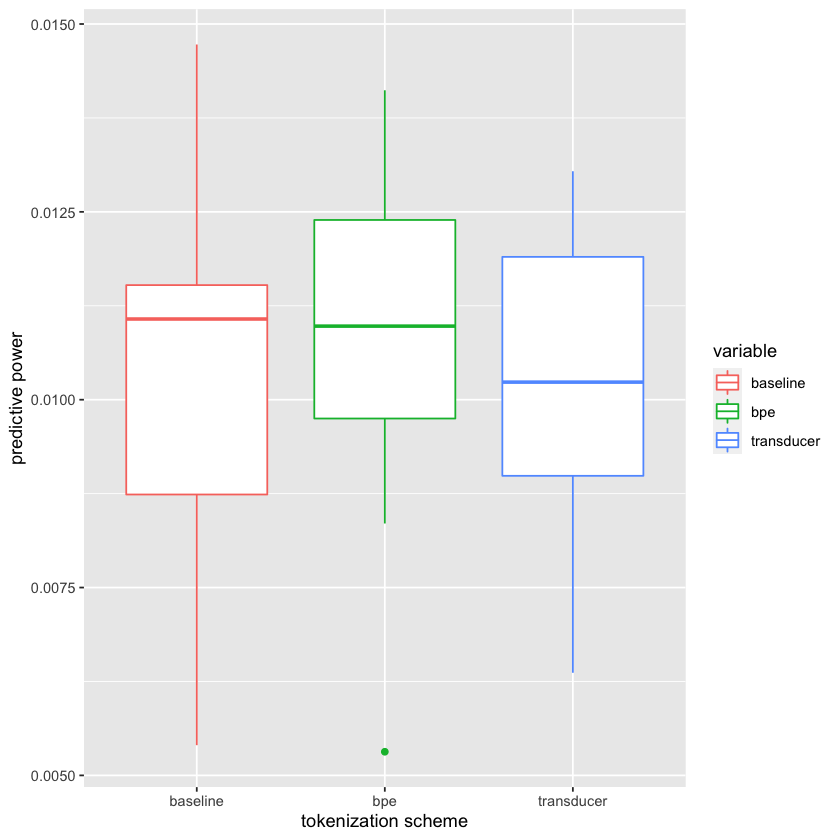

In [182]:
ggplot(melt(cv_results))+ geom_boxplot(aes(x = variable, y = value, color = variable)) + labs(y="predictive power",
                                                                            x = "tokenization scheme")